In [29]:
import pandas as pd

df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])
df['Length']=df['SMS'].apply(len)
print(df.shape)
df.head()

(5572, 3)


,Label,SMS,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<AxesSubplot: ylabel='Label'>

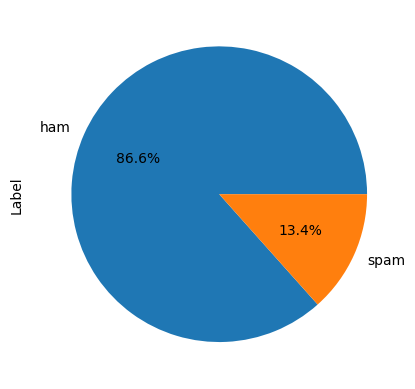

In [30]:
label_counts = df['Label'].value_counts()
label_counts.plot.pie(autopct='%1.1f%%')

------------------------------------------------------------------------------------------------------------------

<font size="6">Media Campionaria</font>
<br>
<br>
 <img title="a title" alt="Alt text" src="img/mediaCapionario.png" width="550" height="130">
<br>

In [31]:
def MediaCampionaria(df):
  totale=0
  for index, row in df.iterrows():
    mail = row[1]
    lunghezza = row[2]
    totale = totale + lunghezza
  return totale/df.shape[0]

In [32]:
MediaCampionaria(df)

80.48994974874371

In [33]:
spam_df = df[df['Label'] == 'spam']
ham_df = df[df['Label'] == 'ham']

print("Media campionaria SPAM:",MediaCampionaria(spam_df))
print("Media campionaria HAM:",MediaCampionaria(ham_df))

Media campionaria SPAM: 138.6706827309237
Media campionaria HAM: 71.48248704663213


------------------------------------------------------------------------------------------------------------------

<font size="6">Mediana Campionaria</font>
<br>
<br>
 <img title="a title" alt="Alt text" src="img/MediaCampionaria.png" width="550" height="200">
<br>

In [34]:
def MedianaCampionaria(df):
  #ordina il dataset 
  df_sorted = df.sort_values(by='Length')
  #se pari
  if (df_sorted.shape[0]%2==0):
    row1 = df_sorted.iloc[int((df_sorted.shape[0]/2))+1]
    row2 = df_sorted.iloc[int((df_sorted.shape[0]/2))]
    return (row1[2] + row2[2])/2 
  else:
    row = df_sorted.iloc[int((df_sorted.shape[0]/2)+1)]
    return row[2]

In [35]:
MedianaCampionaria(df)

62.0

In [36]:
print("Mediana campionaria SPAM:",MedianaCampionaria(spam_df))
print("Mediana campionaria HAM:",MedianaCampionaria(ham_df))

Mediana campionaria SPAM: 149
Mediana campionaria HAM: 52


------------------------------------------------------------------------------------------------------------------

<font size="6">Varianza Campionaria</font>
<br>
<br>
 <img title="a title" alt="Alt text" src="img/varianzaCampionaria.png" width="520" height="120">
<br>


In [37]:
def VarianzaCampionaria(df):
    n = df.shape[0]
    mediaCampionaria = MediaCampionaria(df)
    totale = 0
    for index, row in df.iterrows():
        mailLenght = row[2]
        totale = totale + (mailLenght - mediaCampionaria)**2
    return totale / (n-1)

In [38]:
VarianzaCampionaria(df)

3593.152115811508

<font size="5">Confronto Varianza Campionaria tra messaggi ham e spam</font>


In [39]:


print("Varianza campionaria solo spam", VarianzaCampionaria(spam_df))
print("Varianza campionaria solo ham",VarianzaCampionaria(ham_df))

Varianza campionaria solo spam 833.6849704447815
Varianza campionaria solo ham 3415.309861143342


------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------

<font size="6">Implementazione modello di ML Naive Bayes</font>
<br>
<br>

Suddivisione in test set e training set

In [40]:
# Randomize
data_randomized = df.sample(frac=1, random_state=1)
training_test_index = round(len(data_randomized) * 0.8)

training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 3)
(1114, 3)


Pulizia dei dati 

In [41]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ') # Removes punctuation
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head(3)

C:\Users\mikis\AppData\Local\Temp\ipykernel_34052\1281021717.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ') # Removes punctuation


,Label,SMS,Length
0,ham,yep by the pretty sculpture,28
1,ham,yes princess are you going to make me moan,45
2,ham,welp apparently he retired,26


Per far in modo di conoscere le probabilità P(Ham|mail) e P(Spam|mail)
<br>
<br>
 <img title="a title" alt="Alt text" src="img/ProbSpamDatoParole.png" width="500" height="180">
<br>
<br>
 e necessario calcolare i parametri necessari per valutare la probabilità P(parola|Spam) oppure P(parola|Ham)
<br>
<br>
 <img title="a title" alt="Alt text" src="img/ProbParolaDato.png" width="500" height="185">
<br>
<br>

Calcolo delle probabilita **P(Spam)** e **P(Ham)**

In [42]:
# Dividiamo messaggi spam and ham 
spam_messages = training_set[training_set['Label'] == 'spam']
ham_messages = training_set[training_set['Label'] == 'ham']

# P(Spam) and P(Ham)
#casi favorevoli su casi totali
p_spam = len(spam_messages) / len(training_set)
p_ham = len(ham_messages) / len(training_set)

Calcolo del parametro:
<br>
**n_vocabulary** = il numero di tutte le parole presenti in tutti i messaggi

In [43]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
   for word in sms:
      vocabulary.append(word)

vocabulary = list(set(vocabulary))
n_vocabulary = len(vocabulary)

Calcolo dei parametri:
<br>
**n_spam** = numero totale di parole nei messaggi spam
<br>
**n_ham** = numero totale di parole nei messaggi ham 

In [44]:
# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()
print("n_spam", n_spam)

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()
print("n_ham", n_ham)

n_spam 82756
n_ham 276690


Definizione dello **smoothing parameter**

In [45]:
alpha = 1

Infine è necessario calcolare il numero di volte che una certa parola e presente in messaggi spam/ham 
<br>
<br>
<img title="a title" src="img/ProbParolaDato - Copia.png" width="400" height="170">

In [46]:
#ritorna il numero di istanze della parole "parolaDaCercare" nei messaggi spam
def NParolaInSpam(parolaDaCercare):
    return (spam_messages['SMS'].str.count(parolaDaCercare).sum())

#ritorna il numero di istanze della parole "parolaDaCercare" nei messaggi ham
def NParolaInHam(parolaDaCercare):
    return (ham_messages['SMS'].str.count(parolaDaCercare).sum())


<br>
<br>
Infine queste due funzioni si occuperanno di implementare le formule viste precedentemente

In [47]:
def CalcolaProbParolaDatoSpam(parola):
    #numero di volte che incontriamo la parola in messaggi spam
    num = NParolaInSpam(parola) + alpha
    den = n_spam + (alpha * n_vocabulary)
    return num / den

def CalcolaProbParolaDatoHam(parola):
    #numero di volte che incontriamo la parola in messaggi ham
    num = NParolaInHam(parola) + alpha
    den = n_ham + (alpha * n_vocabulary)
    return num / den

Definiamo la funzione **CalcolaProbHamDatoMail** che implementa la formula 
<br>
<br>
 <img title="a title" alt="Alt text" src="img/ProbSpamDatoParole.png" width="500" height="175">

In [48]:
import string
def pulisciMail(mail):
    mail = mail.translate(str.maketrans('', '', string.punctuation))
    mail = mail.lower()
    return mail

#la funzione prende in input una mail (una stringa) e ritorna P(Ham|mail) ovvero la probabilita che la mail si di tipo ham
# setta stampaProb a true se e necessario stampare le probabilita per ogni singola parola 

def CalcolaProbHamDatoMail(mail,stampaProb):
    #pulizia dei dati
    mail = pulisciMail(mail)
    parole = mail.split()
    totale = 1
    
    for parola in parole:
        prob=CalcolaProbParolaDatoHam(parola)
        if (stampaProb):
            print(f"P({parola}|Ham) =",prob)
        totale = prob * totale

    return totale * p_ham

#la funzione prende in input una mail (una stringa) e ritorna P(Spam|mail) ovvero la probabilita che la mail si di tipo spam
# setta stampaProb a true se e necessario stampare le probabilita per ogni singola parola 
def CalcolaProbSpamDatoMail(mail, stampaProb):
    #pulizia dei dati
    mail = pulisciMail(mail)
    parole = mail.split()
    totale = 1
    
    for parola in parole:
        prob=CalcolaProbParolaDatoSpam(parola)
        if (stampaProb):
            print(f"P({parola}|Spam) =",prob)
        totale = prob * totale

    return totale * p_spam

<br>
<font size="6">Esempio</font>
<br>
<br>
Supponiamo di ricevere la mail:
<br>
<br>
<font size="3" >"Sounds good, Tom, then see u there"</font>

Calcoliamo la probabilità **P(Ham|mail)**
ovvero la probabilità che la mail sia leggittima 

In [49]:
mail = "Sounds good, Tom, then see u there"
print("P(Ham|Sounds good, Tom, then see u there) = P(Ham) P(sounds|Ham) P(good|Ham) ... P(there|Ham) = ",  CalcolaProbHamDatoMail(mail,True))

P(sounds|Ham) = 4.218326519564247e-05
P(good|Ham) = 0.000745237685123017
P(tom|Ham) = 0.0003796493867607822
P(then|Ham) = 0.0006538406105324583
P(see|Ham) = 0.0005308060870451677
P(u|Ham) = 0.02830145567417646
P(there|Ham) = 0.0006257184337353633
P(Ham|Sounds good, Tom, then see u there) = P(Ham) P(sounds|Ham) P(good|Ham) ... P(there|Ham) =  6.347977410574929e-23


Calcoliamo la probabilità **P(Spam|mail)**
ovvero la probabilità che la mail sia illeggittima 

In [50]:
print("P(Spam|Sounds good, Tom, then see u there) = P(Spam) P(sounds|Spam) P(good|Spam) ... P(there|Spam) = ",  CalcolaProbSpamDatoMail(mail,True))

P(sounds|Spam) = 2.2089928097284045e-05
P(good|Spam) = 0.00015462949668098832
P(tom|Spam) = 0.0006185179867239533
P(then|Spam) = 0.00011044964048642022
P(see|Spam) = 0.00017671942477827236
P(u|Spam) = 0.022266647522062314
P(there|Spam) = 0.00015462949668098832
P(Spam|Sounds good, Tom, then see u there) = P(Spam) P(sounds|Spam) P(good|Spam) ... P(there|Spam) =  1.91093509628003e-26


<font size="6" >Conlusione</font>
<br>
<br>
Possiamo notare che:
<br>
<br>
P(Ham|Sounds good, Tom, then see u there) > P(Spam|Sounds good, Tom, then see u there)
<br> 
<br> 
**Dunque il calssificatore classificherà la mail come Ham**

<br>
<br>
<font size="6" >Prestazioni del modello sul test set</font>


In [51]:
def classificaMail (mail):
    probHam = CalcolaProbHamDatoMail(mail,False)
    probSpam = CalcolaProbSpamDatoMail(mail,False)
    
    if (probHam>probSpam):
        return "ham"
    else:
        return "spam"

In [52]:
numeroErrori = 0

for index, row in test_set.iterrows():
   actualLabel = row[0]
   mail = row[1]
   evaluatedLabel = classificaMail(mail)
   if (actualLabel!=evaluatedLabel):
      numeroErrori=numeroErrori+1

print("Totale mail classificate:", test_set.shape[0])
print("Numero mail classificate erroneamente:",numeroErrori)
print("Numero mail classificate correttamente:",test_set.shape[0] - numeroErrori)

#                  numero elementi classificati correttamente
# accuratezza =  -------------------------------------------
#                  numero totale di elementi classificati

print("Accuratezza:",(test_set.shape[0] - numeroErrori)/test_set.shape[0])



Totale mail classificate: 1114
Numero mail classificate erroneamente: 61
Numero mail classificate correttamente: 1053
Accuratezza: 0.9452423698384201
